<a href="https://colab.research.google.com/github/huberyhub/himal_hubery_mateo_DP_Project/blob/main/Further_Implementation_of_Deep_Learning_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import random

# Further Implementation of Deep Learning Final Project

#Data set preprocessing

This code loads and processes DJIA and news headline datasets, merging them by date and labeling data for longer-term trend predictions based on stock price changes. The update includes finding all numerical data for the Dow Jones in addition to the original dataset. The `label_trend` function initializes labels to 0 and calculates short-term and long-term changes in stock prices. If both changes are positive, it labels an upward trend (1); if both are negative, a downward trend (0); otherwise, no clear trend (2). The processed DataFrame is saved to a new CSV file.

In [49]:
# Load the datasets
djia_df = pd.read_csv('/content/upload_DJIA_table.csv')
headlines_df = pd.read_csv('/content/Combined_News_DJIA.csv')

# Reverse the headlines dataset to match the date order with DJIA dataset
headlines_df = headlines_df.iloc[::-1].reset_index(drop=True)

# Combine all headline columns into a single text field
headline_columns = [col for col in headlines_df.columns if col.startswith('Top')]
headlines_df['Combined_Headlines'] = headlines_df[headline_columns].apply(lambda row: ' '.join(row.dropna().values.astype(str)), axis=1)

# Keep only the necessary columns
headlines_df = headlines_df[['Date', 'Combined_Headlines']]

# Merge the datasets on the Date column
merged_df = pd.merge(djia_df, headlines_df, on='Date', how='inner')

# Label the data for longer-term predictions
def label_trend(data, short_term_window=3, long_term_window=15):
    data['Label'] = 0  # Initialize all labels to 0
    for i in range(len(data) - long_term_window):
        short_term_change = data['Close'].iloc[i + short_term_window] - data['Open'].iloc[i]
        long_term_change = data['Close'].iloc[i + long_term_window] - data['Open'].iloc[i]
        if short_term_change > 0 and long_term_change > 0:
            data.loc[i, 'Label'] = 1  # Upward trend
        elif short_term_change < 0 and long_term_change < 0:
            data.loc[i, 'Label'] = 0  # Downward trend
        else:
            data.loc[i, 'Label'] = 2  # No clear trend
    return data

merged_df = label_trend(merged_df)

# Save the merged dataframe to a new CSV file
merged_df.to_csv('/content/Merged_DJIA_Headlines.csv', index=False)

#Define dataset class


This code defines a NewsDataset class for handling news headlines, labels, and optional stock price data. It uses a tokenizer to encode headlines and price information into input tensors suitable for a PyTorch model. The class includes methods to get the dataset length and to retrieve and preprocess individual items, ensuring proper tokenization and padding.

In [50]:
# Define the NewsDataset class
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len, prices=None):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.prices = prices

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        headline = str(self.headlines[idx])
        label = self.labels[idx]
        price_info = self.prices[idx] if self.prices is not None else ""

        if pd.isna(headline):
            headline = ""

        encoding = self.tokenizer.encode_plus(
            headline + " " + price_info,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'headline_text': headline,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define the create_data_loader function

In [51]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    df['Price_Info'] = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].astype(str).agg(' '.join, axis=1)

    ds = NewsDataset(
        headlines=df['Combined_Headlines'].to_numpy(),
        labels=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
        prices=df['Price_Info'].to_numpy()
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=0)

# Training specification

In [52]:
# Example of model training
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model = model.to(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 16

train_data_loader = create_data_loader(merged_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(merged_df, tokenizer, MAX_LEN, BATCH_SIZE) # Make sure to split data for training and validation

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#Define training function

In [53]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Define evaluation function

In [54]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

#Model Training

In [ ]:
# Train and evaluate the model
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(merged_df)  # Assuming merged_df is the training dataset
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,  # Assuming val_data_loader is defined similarly
        loss_fn,
        device,
        len(merged_df)  # Assuming merged_df is the validation dataset
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

# Save the trained model
model_save_path = 'bert_sequence_classification_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Load the saved model
model_load_path = 'bert_sequence_classification_model.pth'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load(model_load_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode
print(f'Model loaded from {model_load_path}')

Epoch 1/10
----------
Train loss 1.093067434310913 accuracy 0.3951734539969834
Val loss 1.0681704244613648 accuracy 0.4233283056812468
Epoch 2/10
----------
Train loss 1.07766752243042 accuracy 0.41880341880341876
Val loss 1.061946400642395 accuracy 0.4233283056812468
Epoch 3/10
----------
Train loss 1.0746863617897033 accuracy 0.41528406234288584
Val loss 1.0404798240661621 accuracy 0.5485168426344896
Epoch 4/10
----------
Train loss 1.032378689289093 accuracy 0.4786324786324786
Val loss 0.9366126942634583 accuracy 0.5661136249371543
Epoch 5/10
----------
Train loss 0.854963840007782 accuracy 0.6173956762192055
Val loss 0.6329040094614029 accuracy 0.7164404223227752
Epoch 6/10
----------
Train loss 0.6694988816976547 accuracy 0.7083961789844142
Val loss 0.5730169392824173 accuracy 0.7410759175465057
Epoch 7/10
----------
Train loss 0.5558750458359718 accuracy 0.7556561085972849
Val loss 0.4724943578243256 accuracy 0.7782805429864252
Epoch 8/10
----------
Train loss 0.4782993077039719 

# Evaluation


This function analyze_misclassifications evaluates a model to identify misclassified examples. It sets the model to evaluation mode, disables gradient calculation, and iterates through a data loader. For each batch, it computes predictions and compares them to the actual labels. If a prediction does not match the label, the text, predicted label, and actual label are saved. The function returns a list of these misclassified examples.

In [61]:
def analyze_misclassifications(model, data_loader, device):
    model = model.eval()

    misclassified_examples = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["headline_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            for text, pred, label in zip(texts, preds, labels):
                if pred != label:
                    misclassified_examples.append((text, pred.item(), label.item()))

    return misclassified_examples

This code evaluates a model's performance by obtaining predictions and true labels from a validation dataset. It calculates and prints the accuracy, generates a detailed classification report, and creates a confusion matrix. The confusion matrix is then visualized using a seaborn heatmap to provide a graphical representation of the model's performance across different classes.

Accuracy: 0.8421
Classification Report:
                precision    recall  f1-score   support

      Downward       0.93      1.00      0.97       842
        Upward       0.94      0.36      0.52       472
No Clear Trend       0.73      0.99      0.84       675

      accuracy                           0.84      1989
     macro avg       0.87      0.78      0.77      1989
  weighted avg       0.87      0.84      0.82      1989



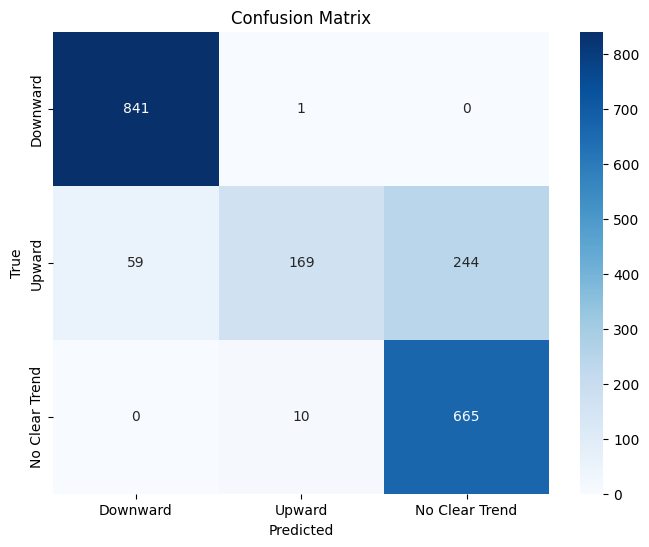

In [62]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get predictions and true labels
def get_predictions(model, data_loader, device):
    model = model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(model, val_data_loader, device)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

# Generate classification report
class_report = classification_report(true_labels, predictions, target_names=['Downward', 'Upward', 'No Clear Trend'])
print('Classification Report:')
print(class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Downward', 'Upward', 'No Clear Trend'], yticklabels=['Downward', 'Upward', 'No Clear Trend'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


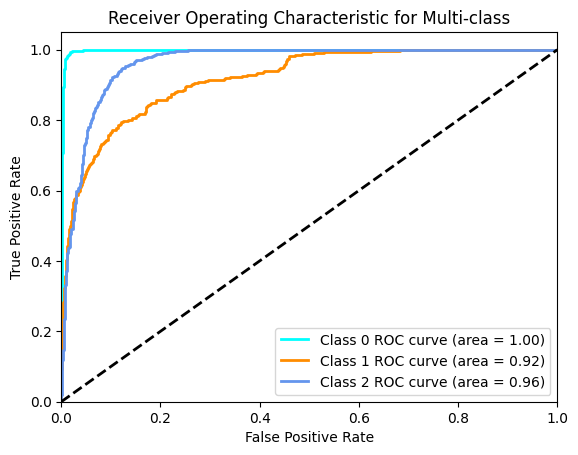

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve_multiclass(model, data_loader, device, num_classes):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_probs = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            # Assuming the model output is logits
            probabilities = torch.softmax(outputs.logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            true_labels.extend(labels)
            pred_probs.extend(probabilities)

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)

    # Binarize the labels for multi-class ROC
    true_labels_binarized = label_binarize(true_labels, classes=list(range(num_classes)))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
                 label=f'Class {i} ROC curve (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Example usage
plot_roc_curve_multiclass(model, val_data_loader, device, num_classes=3)


In [64]:
# Test random headlines
def test_random_headlines(df, tokenizer, model, device, num_samples=5):
    samples = df.sample(n=num_samples)
    for index, row in samples.iterrows():
        headline = row['Combined_Headlines']
        price_info = row['Price_Info'] if 'Price_Info' in row else ""

        encoding = tokenizer.encode_plus(
            headline + " " + price_info,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

        print(f"Headline: {headline}")
        print(f"Predicted: {preds.item()}")
        print("----")

# Test random headlines
test_random_headlines(merged_df, tokenizer, model, device)

Headline: Women in Tokyo are threatening a sex boycott against any man who votes for the front-runner in this weekend's gubernatorial election, in protest at his claim that menstruation makes women unfit for government. UK: Police will have 'backdoor' access to health records despite opt-out, says MP | David Davis says police would be able to approach central NHS database without a warrant as critics warn of catastrophic breach of trust HSBC settlement approved: no criminal charges, 5 weeks' profit in fines, deferred bonuses for laundering billions for narco-terrorists There are spy-cams in Olympic showers, Russian Deputy PM admits Massive protests in cities all over Bosnia. Citizens torching government buildings. China fury at Japanese claim that Nanjing massacre never took place: Board member at Japan's state broadcaster denies infamous wartime slaughter of tens of thousands ever happened Saudi female student dies after male ambulance crew denied access: University officials argued t

The `predict_headlines` function allows manual input of one or multiple headlines to obtain predictions from a trained BERT model. It takes a list of headlines, tokenizes them using the provided tokenizer, and processes them with the model in evaluation mode. Each headline is converted into input IDs and attention masks, which are fed into the model to obtain predictions. The function returns the predicted labels for each headline. This functionality is useful for real-time prediction and evaluation of new, unseen headlines to understand how the model interprets and classifies them based on the training it received.

In [68]:
def predict_headlines(headlines, model, tokenizer, device, max_len=128):
    model = model.eval()
    predictions = []

    for headline in headlines:
        encoding = tokenizer.encode_plus(
            headline,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

        predictions.append(preds.item())

    return predictions

# Example usage
headlines1 = [
    "Stocks rally as new economic data beats expectations",
    "The Fed lower the interest rate"
    "Unemployment rate increase",
    "The Fed increase the interest rate"
]

# For personal implementation
headlines2 = [""
]

predictions1 = predict_headlines(headlines1, model, tokenizer, device)
predictions2 = predict_headlines(headlines2, model, tokenizer, device)

print("Predictions1:", predictions1)
print("Predictions2:", predictions2)


Predictions1: [2, 2, 2]
Predictions2: [2]
